# **Outline of the project : NLP with Disaster tweets**

The project is based on a dataset used in the context of a Kaggle competition (https://www.kaggle.com/c/nlp-getting-started).

The dataset is composed of tweets, the goal is design and build a model that can
predict wether each tweet is related to a actual natural disaster or not. The dataset contains a column 'target' which contains a boolean : 1 if the tweet is related to a disaster and 0 otherwise.

After processing the data, we will compare the performances of different ML and DL models :



####1.   Data preprocessing
####2.   Logistic regression with TD-IDF
####3.   Simple embedding
####4.   Recurent Neural Network (Simple Recurrent Neural)
####5.   Complex recurrent layers (LSTM)




## 1. Data preprocessing

#### 1.1 Quick exploration of the data

First let's retrieve the data and take a first look at the data quality and its structure.

In [5]:
import pandas as pd
import numpy as np
import re

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score, precision_score

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/projet tweet NLP'
data = pd.read_csv(path + '/train.csv')
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [ ]:
# The goal of this project is to focus on NLP so I decided to drop the columns 'keyword' and 'location' (the id can be useful for error analysis if needed).
# By exploring the dataset, I noticed that the data was alphabetically ordoned based on the keyword column so before getting rid of the 'keyword' column, the data will
# be entirely shuffled.
data = data.sample(data.shape[0])
data = data.drop(['keyword', 'location'], axis=1)

In [ ]:
for i in range(50):
  print(data.iloc[i,1])

Sending a snapchat to the wrong person instead of your brother about the toilet ?? ?? ???? #snapchatselfie #wrongperson  #traumatised
16yr old boy pic PKK suicide bomber who detonated bomb in Turkey Army trench http://t.co/H3SXfV5mtC http://t.co/IEWDreNauK
Thunderstorm in Helsinki
#thunder #lightning #lightningstrike #thunderstorm #nature #HelsinkiÛ_ https://t.co/rJJXUcX5PM
Hail! [pic] ÛÓ https://t.co/B7omJ7U3EI
gonna drown it in mustard and lemon pepper :)
@Homukami Only URs and SRs matter Rs you'll be drowning in. Tho you're already drowning in Ns lol.
@UrufuSanRagu a Mudslide?
Sadly the tent fly did not survive this hailstorm and now I have tears in the roof and water in the tent.  Only... http://t.co/zCt5cchOJ0
smoke whatever you got
Domestic terrorism. No ifs ands or buts about it. YOU CREATED THIS @GOP http://t.co/hFgjgFGfeL
HereÛªs what caused a Metro train to derail in downtown D.C. http://t.co/ImTYgdS5qO
#news Cramer: Iger's 3 words that wrecked Disney's stock http://t.co/S

===> It appears that it will be necessary to clean the tweets very carefully since we can see that the texts contain typos, acronyms, contractions, letters duplicated many times, etc.

Finally, let's determine wether the dataset is balanced or not :

In [ ]:
total_tweets = data.shape[0]
disaster_tweets = data.target.sum()
print('There are {:,} tweets in the dataset, {:,} of which are labelled as related to natural disasters ({:.1%}).'.format(total_tweets, disaster_tweets, disaster_tweets/total_tweets))
# ==> The dataset is quite balanced between disaster tweets and non disaster tweets.

There are 7,613 tweets in the dataset, 3,271 of which are labelled as related to natural disasters (43.0%).


#### 1.2 Cleaning data

In order to be able to use NLP models (Natural Language Processing), I will later encode the tweets, meaning we are going to attribute an integer to every word used in the dataset (or at least to the most frequent ones). Thus, it is necessary to clean the tweets in order to make sure that if a word appears in several tweets, it is written exactly the same way. I also need to get rid of all possible special characters that would otherwise compromise the relevance of the encoding process.

As we saw above by looking at several tweets, there are a lot of typos, duplicated letters, contractions to correct... Hopefully, it is possible to find help on the kaggle community as some people published all the mistakes they encountered when dealing with the dataset.

As a consequence, I am using the cleaning function written below which is based on a list mistakes/abreviations found on Kaggle that I updated with other errors I encountered during the realization of this project.

Please note that the function below does not directly deal with punctuations characters, those will be taken care of thanks to the argument 'filter' of Keras text tokenizer (https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer).

In [ ]:
# This function based on regular expressions and used 're.sub' in order to substitute a wrongly typed expression 
#(or at least typed in a way that could hurt the encoding process) with a nicely typed expression.

def clean_tweet(txt):
  """
    txt is the text of a tweet. This functions substitudes all characters that can be issues for text encoding without changing the meaning and context of the sentences.
  """
  # Addition during the realization of this project
  txt = re.sub(r'\w+(http)\w+|(http)\w+', '', txt)
  txt = re.sub(r'\[.+\]', '', txt)
  txt = re.sub(r'\(.+\)', '', txt)
  txt = re.sub(r"LO+L", "lol", txt)
  txt = re.sub(r"goooooooaaaaaal", "goal", txt)
  txt = re.sub(r"Coo+l", "cool", txt)
  txt = re.sub(r"å¤", "", txt)
  txt = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", txt)

  # Encoding issues
  txt = re.sub(r"\x89Û_", "", txt)
  txt = re.sub(r"\x89ÛÒ", "", txt)
  txt = re.sub(r"\x89ÛÓ", "", txt)
  txt = re.sub(r"\x89ÛÏWhen", "When", txt)
  txt = re.sub(r"\x89ÛÏ", "", txt)
  txt = re.sub(r"China\x89Ûªs", "China's", txt)
  txt = re.sub(r"let\x89Ûªs", "let's", txt)
  txt = re.sub(r"\x89Û÷", "", txt)
  txt = re.sub(r"\x89Ûª", "", txt)
  txt = re.sub(r"\x89Û\x9d", "", txt)
  txt = re.sub(r"å_", "", txt)
  txt = re.sub(r"\x89Û¢", "", txt)
  txt = re.sub(r"\x89Û¢åÊ", "", txt)
  txt = re.sub(r"fromåÊwounds", "from wounds", txt)
  txt = re.sub(r"åÊ", "", txt)
  txt = re.sub(r"åÈ", "", txt)
  txt = re.sub(r"JapÌ_n", "Japan", txt)    
  txt = re.sub(r"Ì©", "e", txt)
  txt = re.sub(r"å¨", "", txt)
  txt = re.sub(r"SuruÌ¤", "Suruc", txt)
  txt = re.sub(r"åÇ", "", txt)
  txt = re.sub(r"å£3million", "3 million", txt)
  txt = re.sub(r"åÀ", "", txt)

  # Contractions
  txt = re.sub(r"he's", "he is", txt)
  txt = re.sub(r"there's", "there is", txt)
  txt = re.sub(r"We're", "We are", txt)
  txt = re.sub(r"That's", "That is", txt)
  txt = re.sub(r"won't", "will not", txt)
  txt = re.sub(r"they're", "they are", txt)
  txt = re.sub(r"Can't", "Cannot", txt)
  txt = re.sub(r"wasn't", "was not", txt)
  txt = re.sub(r"don\x89Ûªt", "do not", txt)
  txt = re.sub(r"aren't", "are not", txt)
  txt = re.sub(r"isn't", "is not", txt)
  txt = re.sub(r"What's", "What is", txt)
  txt = re.sub(r"haven't", "have not", txt)
  txt = re.sub(r"hasn't", "has not", txt)
  txt = re.sub(r"There's", "There is", txt)
  txt = re.sub(r"He's", "He is", txt)
  txt = re.sub(r"It's", "It is", txt)
  txt = re.sub(r"You're", "You are", txt)
  txt = re.sub(r"I'M", "I am", txt)
  txt = re.sub(r"shouldn't", "should not", txt)
  txt = re.sub(r"wouldn't", "would not", txt)
  txt = re.sub(r"i'm", "I am", txt)
  txt = re.sub(r"I\x89Ûªm", "I am", txt)
  txt = re.sub(r"I'm", "I am", txt)
  txt = re.sub(r"Isn't", "is not", txt)
  txt = re.sub(r"Here's", "Here is", txt)
  txt = re.sub(r"you've", "you have", txt)
  txt = re.sub(r"you\x89Ûªve", "you have", txt)
  txt = re.sub(r"we're", "we are", txt)
  txt = re.sub(r"what's", "what is", txt)
  txt = re.sub(r"couldn't", "could not", txt)
  txt = re.sub(r"we've", "we have", txt)
  txt = re.sub(r"it\x89Ûªs", "it is", txt)
  txt = re.sub(r"doesn\x89Ûªt", "does not", txt)
  txt = re.sub(r"It\x89Ûªs", "It is", txt)
  txt = re.sub(r"Here\x89Ûªs", "Here is", txt)
  txt = re.sub(r"who's", "who is", txt)
  txt = re.sub(r"I\x89Ûªve", "I have", txt)
  txt = re.sub(r"y'all", "you all", txt)
  txt = re.sub(r"can\x89Ûªt", "cannot", txt)
  txt = re.sub(r"would've", "would have", txt)
  txt = re.sub(r"it'll", "it will", txt)
  txt = re.sub(r"we'll", "we will", txt)
  txt = re.sub(r"wouldn\x89Ûªt", "would not", txt)
  txt = re.sub(r"We've", "We have", txt)
  txt = re.sub(r"he'll", "he will", txt)
  txt = re.sub(r"Y'all", "You all", txt)
  txt = re.sub(r"Weren't", "Were not", txt)
  txt = re.sub(r"Didn't", "Did not", txt)
  txt = re.sub(r"they'll", "they will", txt)
  txt = re.sub(r"they'd", "they would", txt)
  txt = re.sub(r"DON'T", "DO NOT", txt)
  txt = re.sub(r"That\x89Ûªs", "That is", txt)
  txt = re.sub(r"they've", "they have", txt)
  txt = re.sub(r"i'd", "I would", txt)
  txt = re.sub(r"should've", "should have", txt)
  txt = re.sub(r"You\x89Ûªre", "You are", txt)
  txt = re.sub(r"where's", "where is", txt)
  txt = re.sub(r"Don\x89Ûªt", "Do not", txt)
  txt = re.sub(r"we'd", "we would", txt)
  txt = re.sub(r"i'll", "I will", txt)
  txt = re.sub(r"weren't", "were not", txt)
  txt = re.sub(r"They're", "They are", txt)
  txt = re.sub(r"Can\x89Ûªt", "Cannot", txt)
  txt = re.sub(r"you\x89Ûªll", "you will", txt)
  txt = re.sub(r"I\x89Ûªd", "I would", txt)
  txt = re.sub(r"let's", "let us", txt)
  txt = re.sub(r"it's", "it is", txt)
  txt = re.sub(r"can't", "cannot", txt)
  txt = re.sub(r"don't", "do not", txt)
  txt = re.sub(r"you're", "you are", txt)
  txt = re.sub(r"i've", "I have", txt)
  txt = re.sub(r"that's", "that is", txt)
  txt = re.sub(r"i'll", "I will", txt)
  txt = re.sub(r"doesn't", "does not", txt)
  txt = re.sub(r"i'd", "I would", txt)
  txt = re.sub(r"didn't", "did not", txt)
  txt = re.sub(r"ain't", "am not", txt)
  txt = re.sub(r"you'll", "you will", txt)
  txt = re.sub(r"I've", "I have", txt)
  txt = re.sub(r"Don't", "do not", txt)
  txt = re.sub(r"I'll", "I will", txt)
  txt = re.sub(r"I'd", "I would", txt)
  txt = re.sub(r"Let's", "Let us", txt)
  txt = re.sub(r"you'd", "You would", txt)
  txt = re.sub(r"It's", "It is", txt)
  txt = re.sub(r"Ain't", "am not", txt)
  txt = re.sub(r"Haven't", "Have not", txt)
  txt = re.sub(r"Could've", "Could have", txt)
  txt = re.sub(r"youve", "you have", txt)  
  txt = re.sub(r"donå«t", "do not", txt)   
          
  # Character entity references
  txt = re.sub(r"&gt;", ">", txt)
  txt = re.sub(r"&lt;", "<", txt)
  txt = re.sub(r"&amp;", "&", txt)
  
  # Typos, slang and informal abbreviations
  txt = re.sub(r"w/e", "whatever", txt)
  txt = re.sub(r"w/", "with", txt)
  txt = re.sub(r"USAgov", "USA government", txt)
  txt = re.sub(r"recentlu", "recently", txt)
  txt = re.sub(r"Ph0tos", "Photos", txt)
  txt = re.sub(r"amirite", "am I right", txt)
  txt = re.sub(r"exp0sed", "exposed", txt)
  txt = re.sub(r"<3", "love", txt)
  txt = re.sub(r"amageddon", "armageddon", txt)
  txt = re.sub(r"Trfc", "Traffic", txt)
  txt = re.sub(r"8/5/2015", "2015-08-05", txt)
  txt = re.sub(r"WindStorm", "Wind Storm", txt)
  txt = re.sub(r"8/6/2015", "2015-08-06", txt)
  txt = re.sub(r"10:38PM", "10:38 PM", txt)
  txt = re.sub(r"10:30pm", "10:30 PM", txt)
  txt = re.sub(r"16yr", "16 year", txt)
  txt = re.sub(r"lmao", "laughing my ass off", txt)   
  txt = re.sub(r"TRAUMATISED", "traumatized", txt)
    
  # Hashtags and usernames
  txt = re.sub(r"IranDeal", "Iran Deal", txt)
  txt = re.sub(r"ArianaGrande", "Ariana Grande", txt)
  txt = re.sub(r"camilacabello97", "camila cabello", txt) 
  txt = re.sub(r"RondaRousey", "Ronda Rousey", txt)     
  txt = re.sub(r"MTVHottest", "MTV Hottest", txt)
  txt = re.sub(r"TrapMusic", "Trap Music", txt)
  txt = re.sub(r"ProphetMuhammad", "Prophet Muhammad", txt)
  txt = re.sub(r"PantherAttack", "Panther Attack", txt)
  txt = re.sub(r"StrategicPatience", "Strategic Patience", txt)
  txt = re.sub(r"socialnews", "social news", txt)
  txt = re.sub(r"NASAHurricane", "NASA Hurricane", txt)
  txt = re.sub(r"onlinecommunities", "online communities", txt)
  txt = re.sub(r"humanconsumption", "human consumption", txt)
  txt = re.sub(r"Typhoon-Devastated", "Typhoon Devastated", txt)
  txt = re.sub(r"Meat-Loving", "Meat Loving", txt)
  txt = re.sub(r"facialabuse", "facial abuse", txt)
  txt = re.sub(r"LakeCounty", "Lake County", txt)
  txt = re.sub(r"BeingAuthor", "Being Author", txt)
  txt = re.sub(r"withheavenly", "with heavenly", txt)
  txt = re.sub(r"thankU", "thank you", txt)
  txt = re.sub(r"iTunesMusic", "iTunes Music", txt)
  txt = re.sub(r"OffensiveContent", "Offensive Content", txt)
  txt = re.sub(r"WorstSummerJob", "Worst Summer Job", txt)
  txt = re.sub(r"HarryBeCareful", "Harry Be Careful", txt)
  txt = re.sub(r"NASASolarSystem", "NASA Solar System", txt)
  txt = re.sub(r"animalrescue", "animal rescue", txt)
  txt = re.sub(r"KurtSchlichter", "Kurt Schlichter", txt)
  txt = re.sub(r"aRmageddon", "armageddon", txt)
  txt = re.sub(r"Throwingknifes", "Throwing knives", txt)
  txt = re.sub(r"GodsLove", "God's Love", txt)
  txt = re.sub(r"bookboost", "book boost", txt)
  txt = re.sub(r"ibooklove", "I book love", txt)
  txt = re.sub(r"NestleIndia", "Nestle India", txt)
  txt = re.sub(r"realDonaldTrump", "Donald Trump", txt)
  txt = re.sub(r"DavidVonderhaar", "David Vonderhaar", txt)
  txt = re.sub(r"CecilTheLion", "Cecil The Lion", txt)
  txt = re.sub(r"weathernetwork", "weather network", txt)
  txt = re.sub(r"withBioterrorism&use", "with Bioterrorism & use", txt)
  txt = re.sub(r"Hostage&2", "Hostage & 2", txt)
  txt = re.sub(r"GOPDebate", "GOP Debate", txt)
  txt = re.sub(r"RickPerry", "Rick Perry", txt)
  txt = re.sub(r"frontpage", "front page", txt)
  txt = re.sub(r"NewsIntxts", "News In txts", txt)
  txt = re.sub(r"ViralSpell", "Viral Spell", txt)
  txt = re.sub(r"til_now", "until now", txt)
  txt = re.sub(r"volcanoinRussia", "volcano in Russia", txt)
  txt = re.sub(r"ZippedNews", "Zipped News", txt)
  txt = re.sub(r"MicheleBachman", "Michele Bachman", txt)
  txt = re.sub(r"53inch", "53 inch", txt)
  txt = re.sub(r"KerrickTrial", "Kerrick Trial", txt)
  txt = re.sub(r"abstorm", "Alberta Storm", txt)
  txt = re.sub(r"Beyhive", "Beyonce hive", txt)
  txt = re.sub(r"IDFire", "Idaho Fire", txt)
  txt = re.sub(r"DETECTADO", "Detected", txt)
  txt = re.sub(r"RockyFire", "Rocky Fire", txt)
  txt = re.sub(r"Listen/Buy", "Listen / Buy", txt)
  txt = re.sub(r"NickCannon", "Nick Cannon", txt)
  txt = re.sub(r"FaroeIslands", "Faroe Islands", txt)
  txt = re.sub(r"yycstorm", "Calgary Storm", txt)
  txt = re.sub(r"IDPs:", "Internally Displaced People :", txt)
  txt = re.sub(r"ArtistsUnited", "Artists United", txt)
  txt = re.sub(r"ClaytonBryant", "Clayton Bryant", txt)
  txt = re.sub(r"jimmyfallon", "jimmy fallon", txt)
  txt = re.sub(r"justinbieber", "justin bieber", txt)  
  txt = re.sub(r"UTC2015", "UTC 2015", txt)
  txt = re.sub(r"Time2015", "Time 2015", txt)
  txt = re.sub(r"djicemoon", "dj icemoon", txt)
  txt = re.sub(r"LivingSafely", "Living Safely", txt)
  txt = re.sub(r"FIFA16", "Fifa 2016", txt)
  txt = re.sub(r"thisiswhywecanthavenicethings", "this is why we cannot have nice things", txt)
  txt = re.sub(r"bbcnews", "bbc news", txt)
  txt = re.sub(r"UndergroundRailraod", "Underground Railraod", txt)
  txt = re.sub(r"c4news", "c4 news", txt)
  txt = re.sub(r"OBLITERATION", "obliteration", txt)
  txt = re.sub(r"MUDSLIDE", "mudslide", txt)
  txt = re.sub(r"NoSurrender", "No Surrender", txt)
  txt = re.sub(r"NotExplained", "Not Explained", txt)
  txt = re.sub(r"greatbritishbakeoff", "great british bake off", txt)
  txt = re.sub(r"LondonFire", "London Fire", txt)
  txt = re.sub(r"KOTAWeather", "KOTA Weather", txt)
  txt = re.sub(r"LuchaUnderground", "Lucha Underground", txt)
  txt = re.sub(r"KOIN6News", "KOIN 6 News", txt)
  txt = re.sub(r"LiveOnK2", "Live On K2", txt)
  txt = re.sub(r"9NewsGoldCoast", "9 News Gold Coast", txt)
  txt = re.sub(r"nikeplus", "nike plus", txt)
  txt = re.sub(r"david_cameron", "David Cameron", txt)
  txt = re.sub(r"peterjukes", "Peter Jukes", txt)
  txt = re.sub(r"JamesMelville", "James Melville", txt)
  txt = re.sub(r"megynkelly", "Megyn Kelly", txt)
  txt = re.sub(r"cnewslive", "C News Live", txt)
  txt = re.sub(r"JamaicaObserver", "Jamaica Observer", txt)
  txt = re.sub(r"txtLikeItsSeptember11th2001", "txt like it is september 11th 2001", txt)
  txt = re.sub(r"cbplawyers", "cbp lawyers", txt)
  txt = re.sub(r"fewmoretxts", "few more txts", txt)
  txt = re.sub(r"BlackLivesMatter", "Black Lives Matter", txt)
  txt = re.sub(r"cjoyner", "Chris Joyner", txt)
  txt = re.sub(r"ENGvAUS", "England vs Australia", txt)
  txt = re.sub(r"ScottWalker", "Scott Walker", txt)
  txt = re.sub(r"MikeParrActor", "Michael Parr", txt)
  txt = re.sub(r"4PlayThursdays", "Foreplay Thursdays", txt)
  txt = re.sub(r"TGF2015", "Tontitown Grape Festival", txt)
  txt = re.sub(r"realmandyrain", "Mandy Rain", txt)
  txt = re.sub(r"GraysonDolan", "Grayson Dolan", txt)
  txt = re.sub(r"ApolloBrown", "Apollo Brown", txt)
  txt = re.sub(r"saddlebrooke", "Saddlebrooke", txt)
  txt = re.sub(r"TontitownGrape", "Tontitown Grape", txt)
  txt = re.sub(r"AbbsWinston", "Abbs Winston", txt)
  txt = re.sub(r"ShaunKing", "Shaun King", txt)
  txt = re.sub(r"MeekMill", "Meek Mill", txt)
  txt = re.sub(r"TornadoGiveaway", "Tornado Giveaway", txt)
  txt = re.sub(r"GRupdates", "GR updates", txt)
  txt = re.sub(r"SouthDowns", "South Downs", txt)
  txt = re.sub(r"braininjury", "brain injury", txt)
  txt = re.sub(r"auspol", "Australian politics", txt)
  txt = re.sub(r"PlannedParenthood", "Planned Parenthood", txt)
  txt = re.sub(r"calgaryweather", "Calgary Weather", txt)
  txt = re.sub(r"weallheartonedirection", "we all heart one direction", txt)
  txt = re.sub(r"edsheeran", "Ed Sheeran", txt)
  txt = re.sub(r"TrueHeroes", "True Heroes", txt)
  txt = re.sub(r"S3XLEAK", "sex leak", txt)
  txt = re.sub(r"ComplexMag", "Complex Magazine", txt)
  txt = re.sub(r"TheAdvocateMag", "The Advocate Magazine", txt)
  txt = re.sub(r"CityofCalgary", "City of Calgary", txt)
  txt = re.sub(r"EbolaOutbreak", "Ebola Outbreak", txt)
  txt = re.sub(r"SummerFate", "Summer Fate", txt)
  txt = re.sub(r"RAmag", "Royal Academy Magazine", txt)
  txt = re.sub(r"offers2go", "offers to go", txt)
  txt = re.sub(r"foodscare", "food scare", txt)
  txt = re.sub(r"MNPDNashville", "Metropolitan Nashville Police Department", txt)
  txt = re.sub(r"TfLBusAlerts", "TfL Bus Alerts", txt)
  txt = re.sub(r"GamerGate", "Gamer Gate", txt)
  txt = re.sub(r"IHHen", "Humanitarian Relief", txt)
  txt = re.sub(r"spinningbot", "spinning bot", txt)
  txt = re.sub(r"ModiMinistry", "Modi Ministry", txt)
  txt = re.sub(r"TAXIWAYS", "taxi ways", txt)
  txt = re.sub(r"Calum5SOS", "Calum Hood", txt)
  txt = re.sub(r"po_st", "po.st", txt)
  txt = re.sub(r"scoopit", "scoop.it", txt)
  txt = re.sub(r"UltimaLucha", "Ultima Lucha", txt)
  txt = re.sub(r"JonathanFerrell", "Jonathan Ferrell", txt)
  txt = re.sub(r"aria_ahrary", "Aria Ahrary", txt)
  txt = re.sub(r"rapidcity", "Rapid City", txt)
  txt = re.sub(r"OutBid", "outbid", txt)
  txt = re.sub(r"lavenderpoetrycafe", "lavender poetry cafe", txt)
  txt = re.sub(r"EudryLantiqua", "Eudry Lantiqua", txt)
  txt = re.sub(r"15PM", "15 PM", txt)
  txt = re.sub(r"OriginalFunko", "Funko", txt)
  txt = re.sub(r"rightwaystan", "Richard Tan", txt)
  txt = re.sub(r"CindyNoonan", "Cindy Noonan", txt)
  txt = re.sub(r"RT_America", "RT America", txt)
  txt = re.sub(r"narendramodi", "Narendra Modi", txt)
  txt = re.sub(r"BakeOffFriends", "Bake Off Friends", txt)
  txt = re.sub(r"TeamHendrick", "Hendrick Motorsports", txt)
  txt = re.sub(r"alexbelloli", "Alex Belloli", txt)
  txt = re.sub(r"itsjustinstuart", "Justin Stuart", txt)
  txt = re.sub(r"gunsense", "gun sense", txt)
  txt = re.sub(r"DebateQuestionsWeWantToHear", "debate questions we want to hear", txt)
  txt = re.sub(r"RoyalCarribean", "Royal Carribean", txt)
  txt = re.sub(r"samanthaturne19", "Samantha Turner", txt)
  txt = re.sub(r"JonVoyage", "Jon Stewart", txt)
  txt = re.sub(r"renew911health", "renew 911 health", txt)
  txt = re.sub(r"SuryaRay", "Surya Ray", txt)
  txt = re.sub(r"pattonoswalt", "Patton Oswalt", txt)
  txt = re.sub(r"minhazmerchant", "Minhaz Merchant", txt)
  txt = re.sub(r"TLVFaces", "Israel Diaspora Coalition", txt)
  txt = re.sub(r"pmarca", "Marc Andreessen", txt)
  txt = re.sub(r"pdx911", "Portland Police", txt)
  txt = re.sub(r"jamaicaplain", "Jamaica Plain", txt)
  txt = re.sub(r"Japton", "Arkansas", txt)
  txt = re.sub(r"RouteComplex", "Route Complex", txt)
  txt = re.sub(r"INSubcontinent", "Indian Subcontinent", txt)
  txt = re.sub(r"NJTurnpike", "New Jersey Turnpike", txt)
  txt = re.sub(r"Politifiact", "PolitiFact", txt)
  txt = re.sub(r"Hiroshima70", "Hiroshima", txt)
  txt = re.sub(r"GMMBC", "Greater Mt Moriah Baptist Church", txt)
  txt = re.sub(r"versethe", "verse the", txt)
  txt = re.sub(r"TubeStrike", "Tube Strike", txt)
  txt = re.sub(r"MissionHills", "Mission Hills", txt)
  txt = re.sub(r"ProtectDenaliWolves", "Protect Denali Wolves", txt)
  txt = re.sub(r"NANKANA", "Nankana", txt)
  txt = re.sub(r"SAHIB", "Sahib", txt)
  txt = re.sub(r"PAKPATTAN", "Pakpattan", txt)
  txt = re.sub(r"Newz_Sacramento", "News Sacramento", txt)
  txt = re.sub(r"gofundme", "go fund me", txt)
  txt = re.sub(r"pmharper", "Stephen Harper", txt)
  txt = re.sub(r"IvanBerroa", "Ivan Berroa", txt)
  txt = re.sub(r"LosDelSonido", "Los Del Sonido", txt)
  txt = re.sub(r"bancodeseries", "banco de series", txt)
  txt = re.sub(r"timkaine", "Tim Kaine", txt)
  txt = re.sub(r"IdentityTheft", "Identity Theft", txt)
  txt = re.sub(r"AllLivesMatter", "All Lives Matter", txt)
  txt = re.sub(r"mishacollins", "Misha Collins", txt)
  txt = re.sub(r"BillNeelyNBC", "Bill Neely", txt)
  txt = re.sub(r"BeClearOnCancer", "be clear on cancer", txt)
  txt = re.sub(r"Kowing", "Knowing", txt)
  txt = re.sub(r"ScreamQueens", "Scream Queens", txt)
  txt = re.sub(r"AskCharley", "Ask Charley", txt)
  txt = re.sub(r"BlizzHeroes", "Heroes of the Storm", txt)
  txt = re.sub(r"BradleyBrad47", "Bradley Brad", txt)
  txt = re.sub(r"HannaPH", "Typhoon Hanna", txt)
  txt = re.sub(r"meinlcymbals", "MEINL Cymbals", txt)
  txt = re.sub(r"Ptbo", "Peterborough", txt)
  txt = re.sub(r"cnnbrk", "CNN Breaking News", txt)
  txt = re.sub(r"IndianNews", "Indian News", txt)
  txt = re.sub(r"savebees", "save bees", txt)
  txt = re.sub(r"GreenHarvard", "Green Harvard", txt)
  txt = re.sub(r"StandwithPP", "Stand with planned parenthood", txt)
  txt = re.sub(r"hermancranston", "Herman Cranston", txt)
  txt = re.sub(r"WMUR9", "WMUR-TV", txt)
  txt = re.sub(r"RockBottomRadFM", "Rock Bottom Radio", txt)
  txt = re.sub(r"ameenshaikh3", "Ameen Shaikh", txt)
  txt = re.sub(r"ProSyn", "Project Syndicate", txt)
  txt = re.sub(r"Daesh", "ISIS", txt)
  txt = re.sub(r"s2g", "swear to god", txt)
  txt = re.sub(r"listenlive", "listen live", txt)
  txt = re.sub(r"CDCgov", "Centers for Disease Control and Prevention", txt)
  txt = re.sub(r"FoxNew", "Fox News", txt)
  txt = re.sub(r"CBSBigBrother", "Big Brother", txt)
  txt = re.sub(r"JulieDiCaro", "Julie DiCaro", txt)
  txt = re.sub(r"theadvocatemag", "The Advocate Magazine", txt)
  txt = re.sub(r"RohnertParkDPS", "Rohnert Park Police Department", txt)
  txt = re.sub(r"THISIZBWRIGHT", "Bonnie Wright", txt)
  txt = re.sub(r"Popularmmos", "Popular MMOs", txt)
  txt = re.sub(r"WildHorses", "Wild Horses", txt)
  txt = re.sub(r"FantasticFour", "Fantastic Four", txt)
  txt = re.sub(r"HORNDALE", "Horndale", txt)
  txt = re.sub(r"PINER", "Piner", txt)
  txt = re.sub(r"BathAndNorthEastSomerset", "Bath and North East Somerset", txt)
  txt = re.sub(r"thatswhatfriendsarefor", "that is what friends are for", txt)
  txt = re.sub(r"residualincome", "residual income", txt)
  txt = re.sub(r"YahooNewsDigest", "Yahoo News Digest", txt)
  txt = re.sub(r"MalaysiaAirlines", "Malaysia Airlines", txt)
  txt = re.sub(r"AmazonDeals", "Amazon Deals", txt)
  txt = re.sub(r"MissCharleyWebb", "Charley Webb", txt)
  txt = re.sub(r"shoalstraffic", "shoals traffic", txt)
  txt = re.sub(r"GeorgeFoster72", "George Foster", txt)
  txt = re.sub(r"pop2015", "pop 2015", txt)
  txt = re.sub(r"_PokemonCards_", "Pokemon Cards", txt)
  txt = re.sub(r"DianneG", "Dianne Gallagher", txt)
  txt = re.sub(r"KashmirConflict", "Kashmir Conflict", txt)
  txt = re.sub(r"BritishBakeOff", "British Bake Off", txt)
  txt = re.sub(r"FreeKashmir", "Free Kashmir", txt)
  txt = re.sub(r"mattmosley", "Matt Mosley", txt)
  txt = re.sub(r"BishopFred", "Bishop Fred", txt)
  txt = re.sub(r"EndConflict", "End Conflict", txt)
  txt = re.sub(r"EndOccupation", "End Occupation", txt)
  txt = re.sub(r"UNHEALED", "unhealed", txt)
  txt = re.sub(r"CharlesDagnall", "Charles Dagnall", txt)
  txt = re.sub(r"Latestnews", "Latest news", txt)
  txt = re.sub(r"KindleCountdown", "Kindle Countdown", txt)
  txt = re.sub(r"NoMoreHandouts", "No More Handouts", txt)
  txt = re.sub(r"datingtips", "dating tips", txt)
  txt = re.sub(r"charlesadler", "Charles Adler", txt)
  txt = re.sub(r"twia", "Texas Windstorm Insurance Association", txt)
  txt = re.sub(r"txlege", "Texas Legislature", txt)
  txt = re.sub(r"WindstormInsurer", "Windstorm Insurer", txt)
  txt = re.sub(r"Newss", "News", txt)
  txt = re.sub(r"hempoil", "hemp oil", txt)
  txt = re.sub(r"CommoditiesAre", "Commodities are", txt)
  txt = re.sub(r"tubestrike", "tube strike", txt)
  txt = re.sub(r"JoeNBC", "Joe Scarborough", txt)
  txt = re.sub(r"LiteraryCakes", "Literary Cakes", txt)
  txt = re.sub(r"TI5", "The International 5", txt)
  txt = re.sub(r"thehill", "the hill", txt)
  txt = re.sub(r"3others", "3 others", txt)
  txt = re.sub(r"stighefootball", "Sam Tighe", txt)
  txt = re.sub(r"whatstheimportantvideo", "what is the important video", txt)
  txt = re.sub(r"ClaudioMeloni", "Claudio Meloni", txt)
  txt = re.sub(r"DukeSkywalker", "Duke Skywalker", txt)
  txt = re.sub(r"carsonmwr", "Fort Carson", txt)
  txt = re.sub(r"offdishduty", "off dish duty", txt)
  txt = re.sub(r"andword", "and word", txt)
  txt = re.sub(r"rhodeisland", "Rhode Island", txt)
  txt = re.sub(r"easternoregon", "Eastern Oregon", txt)
  txt = re.sub(r"WAwildfire", "Washington Wildfire", txt)
  txt = re.sub(r"fingerrockfire", "Finger Rock Fire", txt)
  txt = re.sub(r"57am", "57 am", txt)
  txt = re.sub(r"fingerrockfire", "Finger Rock Fire", txt)
  txt = re.sub(r"JacobHoggard", "Jacob Hoggard", txt)
  txt = re.sub(r"newnewnew", "new new new", txt)
  txt = re.sub(r"under50", "under 50", txt)
  txt = re.sub(r"getitbeforeitsgone", "get it before it is gone", txt)
  txt = re.sub(r"freshoutofthebox", "fresh out of the box", txt)
  txt = re.sub(r"amwriting", "am writing", txt)
  txt = re.sub(r"Bokoharm", "Boko Haram", txt)
  txt = re.sub(r"Nowlike", "Now like", txt)
  txt = re.sub(r"seasonfrom", "season from", txt)
  txt = re.sub(r"epicente", "epicenter", txt)
  txt = re.sub(r"epicenterr", "epicenter", txt)
  txt = re.sub(r"sicklife", "sick life", txt)
  txt = re.sub(r"yycweather", "Calgary Weather", txt)
  txt = re.sub(r"calgarysun", "Calgary Sun", txt)
  txt = re.sub(r"approachng", "approaching", txt)
  txt = re.sub(r"evng", "evening", txt)
  txt = re.sub(r"Sumthng", "something", txt)
  txt = re.sub(r"EllenPompeo", "Ellen Pompeo", txt)
  txt = re.sub(r"shondarhimes", "Shonda Rhimes", txt)
  txt = re.sub(r"ABCNetwork", "ABC Network", txt)
  txt = re.sub(r"SushmaSwaraj", "Sushma Swaraj", txt)
  txt = re.sub(r"pray4japan", "Pray for Japan", txt)
  txt = re.sub(r"hope4japan", "Hope for Japan", txt)
  txt = re.sub(r"Illusionimagess", "Illusion images", txt)
  txt = re.sub(r"SummerUnderTheStars", "Summer Under The Stars", txt)
  txt = re.sub(r"ShallWeDance", "Shall We Dance", txt)
  txt = re.sub(r"TCMParty", "TCM Party", txt)
  txt = re.sub(r"marijuananews", "marijuana news", txt)
  txt = re.sub(r"onbeingwithKristaTippett", "on being with Krista Tippett", txt)
  txt = re.sub(r"Beingtxts", "Being txts", txt)
  txt = re.sub(r"newauthors", "new authors", txt)
  txt = re.sub(r"remedyyyy", "remedy", txt)
  txt = re.sub(r"44PM", "44 PM", txt)
  txt = re.sub(r"HeadlinesApp", "Headlines App", txt)
  txt = re.sub(r"40PM", "40 PM", txt)
  txt = re.sub(r"myswc", "Severe Weather Center", txt)
  txt = re.sub(r"ithats", "that is", txt)
  txt = re.sub(r"icouldsitinthismomentforever", "I could sit in this moment forever", txt)
  txt = re.sub(r"FatLoss", "Fat Loss", txt)
  txt = re.sub(r"02PM", "02 PM", txt)
  txt = re.sub(r"MetroFmTalk", "Metro Fm Talk", txt)
  txt = re.sub(r"Bstrd", "bastard", txt)
  txt = re.sub(r"bldy", "bloody", txt)
  txt = re.sub(r"MetrofmTalk", "Metro Fm Talk", txt)
  txt = re.sub(r"terrorismturn", "terrorism turn", txt)
  txt = re.sub(r"BBCNewsAsia", "BBC News Asia", txt)
  txt = re.sub(r"BehindTheScenes", "Behind The Scenes", txt)
  txt = re.sub(r"GeorgeTakei", "George Takei", txt)
  txt = re.sub(r"WomensWeeklyMag", "Womens Weekly Magazine", txt)
  txt = re.sub(r"SurvivorsGuidetoEarth", "Survivors Guide to Earth", txt)
  txt = re.sub(r"incubusband", "incubus band", txt)
  txt = re.sub(r"Babypicturethis", "Baby picture this", txt)
  txt = re.sub(r"BombEffects", "Bomb Effects", txt)
  txt = re.sub(r"win10", "Windows 10", txt)
  txt = re.sub(r"idkidk", "I do not know I do not know", txt)
  txt = re.sub(r"TheWalkingDead", "The Walking Dead", txt)
  txt = re.sub(r"amyschumer", "Amy Schumer", txt)
  txt = re.sub(r"crewlist", "crew list", txt)
  txt = re.sub(r"Erdogans", "Erdogan", txt)
  txt = re.sub(r"BBCLive", "BBC Live", txt)
  txt = re.sub(r"TonyAbbottMHR", "Tony Abbott", txt)
  txt = re.sub(r"paulmyerscough", "Paul Myerscough", txt)
  txt = re.sub(r"georgegallagher", "George Gallagher", txt)
  txt = re.sub(r"JimmieJohnson", "Jimmie Johnson", txt)
  txt = re.sub(r"pctool", "pc tool", txt)
  txt = re.sub(r"DoingHashtagsRight", "Doing Hashtags Right", txt)
  txt = re.sub(r"ThrowbackThursday", "Throwback Thursday", txt)
  txt = re.sub(r"SnowBackSunday", "Snowback Sunday", txt)
  txt = re.sub(r"LakeEffect", "Lake Effect", txt)
  txt = re.sub(r"RTphotographyUK", "Richard Thomas Photography UK", txt)
  txt = re.sub(r"BigBang_CBS", "Big Bang CBS", txt)
  txt = re.sub(r"writerslife", "writers life", txt)
  txt = re.sub(r"NaturalBirth", "Natural Birth", txt)
  txt = re.sub(r"UnusualWords", "Unusual Words", txt)
  txt = re.sub(r"wizkhalifa", "Wiz Khalifa", txt)
  txt = re.sub(r"acreativedc", "a creative DC", txt)
  txt = re.sub(r"vscodc", "vsco DC", txt)
  txt = re.sub(r"VSCOcam", "vsco camera", txt)
  txt = re.sub(r"TheBEACHDC", "The beach DC", txt)
  txt = re.sub(r"buildingmuseum", "building museum", txt)
  txt = re.sub(r"WorldOil", "World Oil", txt)
  txt = re.sub(r"redwedding", "red wedding", txt)
  txt = re.sub(r"AmazingRaceCanada", "Amazing Race Canada", txt)
  txt = re.sub(r"WakeUpAmerica", "Wake Up America", txt)
  txt = re.sub(r"\\Allahuakbar\\", "Allahu Akbar", txt)
  txt = re.sub(r"bleased", "blessed", txt)
  txt = re.sub(r"nigeriantribune", "Nigerian Tribune", txt)
  txt = re.sub(r"HIDEO_KOJIMA_EN", "Hideo Kojima", txt)
  txt = re.sub(r"FusionFestival", "Fusion Festival", txt)
  txt = re.sub(r"50Mixed", "50 Mixed", txt)
  txt = re.sub(r"NoAgenda", "No Agenda", txt)
  txt = re.sub(r"WhiteGenocide", "White Genocide", txt)
  txt = re.sub(r"dirtylying", "dirty lying", txt)
  txt = re.sub(r"SyrianRefugees", "Syrian Refugees", txt)
  txt = re.sub(r"changetheworld", "change the world", txt)
  txt = re.sub(r"Ebolacase", "Ebola case", txt)
  txt = re.sub(r"mcgtech", "mcg technologies", txt)
  txt = re.sub(r"withweapons", "with weapons", txt)
  txt = re.sub(r"advancedwarfare", "advanced warfare", txt)
  txt = re.sub(r"letsFootball", "let us Football", txt)
  txt = re.sub(r"LateNiteMix", "late night mix", txt)
  txt = re.sub(r"PhilCollinsFeed", "Phil Collins", txt)
  txt = re.sub(r"RudyHavenstein", "Rudy Havenstein", txt)
  txt = re.sub(r"22PM", "22 PM", txt)
  txt = re.sub(r"54am", "54 AM", txt)
  txt = re.sub(r"38am", "38 AM", txt)
  txt = re.sub(r"OldFolkExplainStuff", "Old Folk Explain Stuff", txt)
  txt = re.sub(r"BlacklivesMatter", "Black Lives Matter", txt)
  txt = re.sub(r"InsaneLimits", "Insane Limits", txt)
  txt = re.sub(r"youcantsitwithus", "you cannot sit with us", txt)
  txt = re.sub(r"2k15", "2015", txt)
  txt = re.sub(r"TheIran", "Iran", txt)
  txt = re.sub(r"JimmyFallon", "Jimmy Fallon", txt)
  txt = re.sub(r"AlbertBrooks", "Albert Brooks", txt)
  txt = re.sub(r"defense_news", "defense news", txt)
  txt = re.sub(r"nuclearrcSA", "Nuclear Risk Control Self Assessment", txt)
  txt = re.sub(r"Auspol", "Australia Politics", txt)
  txt = re.sub(r"NuclearPower", "Nuclear Power", txt)
  txt = re.sub(r"WhiteTerrorism", "White Terrorism", txt)
  txt = re.sub(r"truthfrequencyradio", "Truth Frequency Radio", txt)
  txt = re.sub(r"ErasureIsNotEquality", "Erasure is not equality", txt)
  txt = re.sub(r"ProBonoNews", "Pro Bono News", txt)
  txt = re.sub(r"JakartaPost", "Jakarta Post", txt)
  txt = re.sub(r"toopainful", "too painful", txt)
  txt = re.sub(r"melindahaunton", "Melinda Haunton", txt)
  txt = re.sub(r"NoNukes", "No Nukes", txt)
  txt = re.sub(r"curryspcworld", "Currys PC World", txt)
  txt = re.sub(r"ineedcake", "I need cake", txt)
  txt = re.sub(r"blackforestgateau", "black forest gateau", txt)
  txt = re.sub(r"BBCOne", "BBC One", txt)
  txt = re.sub(r"AlexxPage", "Alex Page", txt)
  txt = re.sub(r"jonathanserrie", "Jonathan Serrie", txt)
  txt = re.sub(r"SocialJerkBlog", "Social Jerk Blog", txt)
  txt = re.sub(r"ChelseaVPeretti", "Chelsea Peretti", txt)
  txt = re.sub(r"irongiant", "iron giant", txt)
  txt = re.sub(r"RonFunches", "Ron Funches", txt)
  txt = re.sub(r"TimCook", "Tim Cook", txt)
  txt = re.sub(r"sebastianstanisaliveandwell", "Sebastian Stan is alive and well", txt)
  txt = re.sub(r"Madsummer", "Mad summer", txt)
  txt = re.sub(r"NowYouKnow", "Now you know", txt)
  txt = re.sub(r"concertphotography", "concert photography", txt)
  txt = re.sub(r"TomLandry", "Tom Landry", txt)
  txt = re.sub(r"showgirldayoff", "show girl day off", txt)
  txt = re.sub(r"Yougslavia", "Yugoslavia", txt)
  txt = re.sub(r"QuantumDataInformatics", "Quantum Data Informatics", txt)
  txt = re.sub(r"FromTheDesk", "From The Desk", txt)
  txt = re.sub(r"TheaterTrial", "Theater Trial", txt)
  txt = re.sub(r"CatoInstitute", "Cato Institute", txt)
  txt = re.sub(r"EmekaGift", "Emeka Gift", txt)
  txt = re.sub(r"LetsBe_Rational", "Let us be rational", txt)
  txt = re.sub(r"Cynicalreality", "Cynical reality", txt)
  txt = re.sub(r"FredOlsenCruise", "Fred Olsen Cruise", txt)
  txt = re.sub(r"NotSorry", "not sorry", txt)
  txt = re.sub(r"UseYourWords", "use your words", txt)
  txt = re.sub(r"WordoftheDay", "word of the day", txt)
  txt = re.sub(r"Dictionarycom", "Dictionary.com", txt)
  txt = re.sub(r"TheBrooklynLife", "The Brooklyn Life", txt)
  txt = re.sub(r"jokethey", "joke they", txt)
  txt = re.sub(r"nflweek1picks", "NFL week 1 picks", txt)
  txt = re.sub(r"uiseful", "useful", txt)
  txt = re.sub(r"JusticeDotOrg", "The American Association for Justice", txt)
  txt = re.sub(r"autoaccidents", "auto accidents", txt)
  txt = re.sub(r"SteveGursten", "Steve Gursten", txt)
  txt = re.sub(r"MichiganAutoLaw", "Michigan Auto Law", txt)
  txt = re.sub(r"birdgang", "bird gang", txt)
  txt = re.sub(r"nflnetwork", "NFL Network", txt)
  txt = re.sub(r"NYDNSports", "NY Daily News Sports", txt)
  txt = re.sub(r"RVacchianoNYDN", "Ralph Vacchiano NY Daily News", txt)
  txt = re.sub(r"EdmontonEsks", "Edmonton Eskimos", txt)
  txt = re.sub(r"david_brelsford", "David Brelsford", txt)
  txt = re.sub(r"TOI_India", "The Times of India", txt)
  txt = re.sub(r"hegot", "he got", txt)
  txt = re.sub(r"SkinsOn9", "Skins on 9", txt)
  txt = re.sub(r"sothathappened", "so that happened", txt)
  txt = re.sub(r"LCOutOfDoors", "LC Out Of Doors", txt)
  txt = re.sub(r"NationFirst", "Nation First", txt)
  txt = re.sub(r"IndiaToday", "India Today", txt)
  txt = re.sub(r"HLPS", "helps", txt)
  txt = re.sub(r"HOSTAGESTHROSW", "hostages throw", txt)
  txt = re.sub(r"SNCTIONS", "sanctions", txt)
  txt = re.sub(r"BidTime", "Bid Time", txt)
  txt = re.sub(r"crunchysensible", "crunchy sensible", txt)
  txt = re.sub(r"RandomActsOfRomance", "Random acts of romance", txt)
  txt = re.sub(r"MomentsAtHill", "Moments at hill", txt)
  txt = re.sub(r"eatshit", "eat shit", txt)
  txt = re.sub(r"liveleakfun", "live leak fun", txt)
  txt = re.sub(r"SahelNews", "Sahel News", txt)
  txt = re.sub(r"abc7newsbayarea", "ABC 7 News Bay Area", txt)
  txt = re.sub(r"facilitiesmanagement", "facilities management", txt)
  txt = re.sub(r"facilitydude", "facility dude", txt)
  txt = re.sub(r"CampLogistics", "Camp logistics", txt)
  txt = re.sub(r"alaskapublic", "Alaska public", txt)
  txt = re.sub(r"MarketResearch", "Market Research", txt)
  txt = re.sub(r"AccuracyEsports", "Accuracy Esports", txt)
  txt = re.sub(r"TheBodyShopAust", "The Body Shop Australia", txt)
  txt = re.sub(r"yychail", "Calgary hail", txt)
  txt = re.sub(r"yyctraffic", "Calgary traffic", txt)
  txt = re.sub(r"eliotschool", "eliot school", txt)
  txt = re.sub(r"TheBrokenCity", "The Broken City", txt)
  txt = re.sub(r"OldsFireDept", "Olds Fire Department", txt)
  txt = re.sub(r"RiverComplex", "River Complex", txt)
  txt = re.sub(r"fieldworksmells", "field work smells", txt)
  txt = re.sub(r"IranElection", "Iran Election", txt)
  txt = re.sub(r"glowng", "glowing", txt)
  txt = re.sub(r"kindlng", "kindling", txt)
  txt = re.sub(r"riggd", "rigged", txt)
  txt = re.sub(r"slownewsday", "slow news day", txt)
  txt = re.sub(r"MyanmarFlood", "Myanmar Flood", txt)
  txt = re.sub(r"abc7chicago", "ABC 7 Chicago", txt)
  txt = re.sub(r"copolitics", "Colorado Politics", txt)
  txt = re.sub(r"AdilGhumro", "Adil Ghumro", txt)
  txt = re.sub(r"netbots", "net bots", txt)
  txt = re.sub(r"byebyeroad", "bye bye road", txt)
  txt = re.sub(r"massiveflooding", "massive flooding", txt)
  txt = re.sub(r"EndofUS", "End of United States", txt)
  txt = re.sub(r"35PM", "35 PM", txt)
  txt = re.sub(r"greektheatrela", "Greek Theatre Los Angeles", txt)
  txt = re.sub(r"76mins", "76 minutes", txt)
  txt = re.sub(r"publicsafetyfirst", "public safety first", txt)
  txt = re.sub(r"livesmatter", "lives matter", txt)
  txt = re.sub(r"myhometown", "my hometown", txt)
  txt = re.sub(r"tankerfire", "tanker fire", txt)
  txt = re.sub(r"MEMORIALDAY", "memorial day", txt)
  txt = re.sub(r"MEMORIAL_DAY", "memorial day", txt)
  txt = re.sub(r"instaxbooty", "instagram booty", txt)
  txt = re.sub(r"Jerusalem_Post", "Jerusalem Post", txt)
  txt = re.sub(r"WayneRooney_INA", "Wayne Rooney", txt)
  txt = re.sub(r"VirtualReality", "Virtual Reality", txt)
  txt = re.sub(r"OculusRift", "Oculus Rift", txt)
  txt = re.sub(r"OwenJones84", "Owen Jones", txt)
  txt = re.sub(r"jeremycorbyn", "Jeremy Corbyn", txt)
  txt = re.sub(r"paulrogers002", "Paul Rogers", txt)
  txt = re.sub(r"mortalkombatx", "Mortal Kombat X", txt)
  txt = re.sub(r"mortalkombat", "Mortal Kombat", txt)
  txt = re.sub(r"FilipeCoelho92", "Filipe Coelho", txt)
  txt = re.sub(r"OnlyQuakeNews", "Only Quake News", txt)
  txt = re.sub(r"kostumes", "costumes", txt)
  txt = re.sub(r"YEEESSSS", "yes", txt)
  txt = re.sub(r"ToshikazuKatayama", "Toshikazu Katayama", txt)
  txt = re.sub(r"IntlDevelopment", "Intl Development", txt)
  txt = re.sub(r"ExtremeWeather", "Extreme Weather", txt)
  txt = re.sub(r"WereNotGruberVoters", "We are not gruber voters", txt)
  txt = re.sub(r"NewsThousands", "News Thousands", txt)
  txt = re.sub(r"EdmundAdamus", "Edmund Adamus", txt)
  txt = re.sub(r"EyewitnessWV", "Eye witness WV", txt)
  txt = re.sub(r"PhiladelphiaMuseu", "Philadelphia Museum", txt)
  txt = re.sub(r"DublinComicCon", "Dublin Comic Con", txt)
  txt = re.sub(r"NicholasBrendon", "Nicholas Brendon", txt)
  txt = re.sub(r"Alltheway80s", "All the way 80s", txt)
  txt = re.sub(r"FromTheField", "From the field", txt)
  txt = re.sub(r"NorthIowa", "North Iowa", txt)
  txt = re.sub(r"WillowFire", "Willow Fire", txt)
  txt = re.sub(r"MadRiverComplex", "Mad River Complex", txt)
  txt = re.sub(r"feelingmanly", "feeling manly", txt)
  txt = re.sub(r"stillnotoverit", "still not over it", txt)
  txt = re.sub(r"FortitudeValley", "Fortitude Valley", txt)
  txt = re.sub(r"CoastpowerlineTramTr", "Coast powerline", txt)
  txt = re.sub(r"ServicesGold", "Services Gold", txt)
  txt = re.sub(r"NewsbrokenEmergency", "News broken emergency", txt)
  txt = re.sub(r"Evaucation", "evacuation", txt)
  txt = re.sub(r"leaveevacuateexitbe", "leave evacuate exit be", txt)
  txt = re.sub(r"P_EOPLE", "PEOPLE", txt)
  txt = re.sub(r"Tubestrike", "tube strike", txt)
  txt = re.sub(r"CLASS_SICK", "CLASS SICK", txt)
  txt = re.sub(r"localplumber", "local plumber", txt)
  txt = re.sub(r"awesomejobsiri", "awesome job siri", txt)
  txt = re.sub(r"PayForItHow", "Pay for it how", txt)
  txt = re.sub(r"ThisIsAfrica", "This is Africa", txt)
  txt = re.sub(r"crimeairnetwork", "crime air network", txt)
  txt = re.sub(r"KimAcheson", "Kim Acheson", txt)
  txt = re.sub(r"cityofcalgary", "City of Calgary", txt)
  txt = re.sub(r"prosyndicate", "pro syndicate", txt)
  txt = re.sub(r"660NEWS", "660 NEWS", txt)
  txt = re.sub(r"BusInsMagazine", "Business Insurance Magazine", txt)
  txt = re.sub(r"wfocus", "focus", txt)
  txt = re.sub(r"ShastaDam", "Shasta Dam", txt)
  txt = re.sub(r"go2MarkFranco", "Mark Franco", txt)
  txt = re.sub(r"StephGHinojosa", "Steph Hinojosa", txt)
  txt = re.sub(r"Nashgrier", "Nash Grier", txt)
  txt = re.sub(r"NashNewVideo", "Nash new video", txt)
  txt = re.sub(r"IWouldntGetElectedBecause", "I would not get elected because", txt)
  txt = re.sub(r"SHGames", "Sledgehammer Games", txt)
  txt = re.sub(r"bedhair", "bed hair", txt)
  txt = re.sub(r"JoelHeyman", "Joel Heyman", txt)
  txt = re.sub(r"viaYouTube", "via YouTube", txt)
        
  # Acronyms
  txt = re.sub(r"MH370", "Malaysia Airlines Flight 370", txt)
  txt = re.sub(r"mÌ¼sica", "music", txt)
  txt = re.sub(r"okwx", "Oklahoma City Weather", txt)
  txt = re.sub(r"arwx", "Arkansas Weather", txt)    
  txt = re.sub(r"gawx", "Georgia Weather", txt)  
  txt = re.sub(r"scwx", "South Carolina Weather", txt)  
  txt = re.sub(r"cawx", "California Weather", txt)
  txt = re.sub(r"tnwx", "Tennessee Weather", txt)
  txt = re.sub(r"azwx", "Arizona Weather", txt)  
  txt = re.sub(r"alwx", "Alabama Weather", txt)
  txt = re.sub(r"wordpressdotcom", "wordpress", txt)    
  txt = re.sub(r"usNWSgov", "United States National Weather Service", txt)
  txt = re.sub(r"Suruc", "Sanliurfa", txt)

  # Grouping same words without embeddings
  txt = re.sub(r"Bestnaijamade", "bestnaijamade", txt)
  txt = re.sub(r"SOUDELOR", "Soudelor", txt)
    
  return txt.lower().strip()

In [ ]:
data['clean_tweet'] = data['text'].apply(lambda x : clean_tweet(x))

In [ ]:
# Let's take a look to the cleaned tweets :
data[['text', 'clean_tweet']].head(20)

,text,clean_tweet
6895,Sending a snapchat to the wrong person instead...,sending a snapchat to the wrong person instead...
6394,16yr old boy pic PKK suicide bomber who detona...,16 year old boy pic pkk suicide bomber who det...
6735,Thunderstorm in Helsinki\n#thunder #lightning ...,thunderstorm in helsinki\n#thunder #lightning ...
4092,Hail! [pic] ÛÓ https://t.co/B7omJ7U3EI,hail! ://t.co/b7omj7u3ei
2906,gonna drown it in mustard and lemon pepper :),gonna drown it in mustard and lemon pepper :)
2988,@Homukami Only URs and SRs matter Rs you'll be...,@homukami only urs and srs matter rs you will ...
5035,@UrufuSanRagu a Mudslide?,@urufusanragu a mudslide?
4124,Sadly the tent fly did not survive this hailst...,sadly the tent fly did not survive this hailst...
6198,smoke whatever you got,smoke whatever you got
6612,Domestic terrorism. No ifs ands or buts about ...,domestic terrorism. no ifs ands or buts about ...


The tweets now appear to be much cleaner but actually, two additional preprocessing technique will be conducted thanks to the Keras tokenizer :

1.   Removal of all punctuations characters (including @ and #)
2.   Selection of only the N most frequent words

As an example, the string '@dauntedpsyche' in the last tweet above will transformed as 'dauntedpsyche' but then is very unlikely to be kept by the encoder as we don't expect this expression to appear frequently.

On the other hand, the string '#news' will be transformed as 'news' and is likely to be kept as it may appear frequently.

Finally, we could has 'lemmatize' the texts and remove 'stop words' in order to focus only on key words in the tweet. By doing so, we would lost the main part of the context and so we would not be able to fully exploit the advantages of Recurrent Neural Networks which were designed to capture the meaning enclosed in a particular sequence of data. 


In [ ]:
data.to_csv('clean_tweets.csv', index=False)
!cp clean_tweets.csv "drive/My Drive/Colab Notebooks/projet tweet NLP"

In [7]:
# If necessary, we can retrieve the cleaned tweet by running this cell instead of going all the cells of the 'preprocessing' section.
path = '/content/drive/MyDrive/Colab Notebooks/projet tweet NLP'
data = pd.read_csv(path + '/clean_train.csv',  dtype={'target': int, 'lean_tweet': str} ).dropna(subset=['clean_tweet'])
data

,id,keyword,location,text,target,clean_tweet
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...
...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,two giant cranes holding a bridge collapse int...
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,aria ahrary thetawniest the out of control wil...
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,m194 5km s of volcano hawaii
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,police investigating after an ebike collided w...


## 2. Logistic Regression

We saw above that the dataset is composed of 43% of tweets actually related to natural disasters. Thus, we can consider that the performance of a 'baseline model' would be an accuracy of ~43%.

In order to provide additional context on the performances of the Deep Learning models that will be used in section 3, 4 and 5, we define here a logistic regression based on data processed with TF-IDF at one-word level.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(data["clean_tweet"], data["target"], random_state=0, stratify=data["target"], test_size=0.2)

In [26]:
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', ngram_range=(1, 1), max_features=1000) # At this point, we decide to keep only the 1,000 most frequent words. It could be interesting to find the optimal value for this parameter.
tfidf_vect.fit(X_train)
X_train_tfidf =  tfidf_vect.transform(X_train)
X_test_tfidf =  tfidf_vect.transform(X_test)
print("word level tf-idf done")

word level tf-idf done


In [27]:
classifier = LogisticRegression()
classifier.fit(X_train_tfidf,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [28]:
print(classification_report(y_train, classifier.predict(X_train_tfidf)))

              precision    recall  f1-score   support

           0       0.82      0.92      0.87      3472
           1       0.87      0.73      0.80      2613

    accuracy                           0.84      6085
   macro avg       0.85      0.83      0.83      6085
weighted avg       0.84      0.84      0.84      6085



In [29]:
print(classification_report(y_test, classifier.predict(X_test_tfidf)))

              precision    recall  f1-score   support

           0       0.79      0.88      0.84       868
           1       0.82      0.70      0.75       654

    accuracy                           0.80      1522
   macro avg       0.81      0.79      0.79      1522
weighted avg       0.81      0.80      0.80      1522



In [83]:
print('**** conclusion for the logistic regression ****')
print('We obtained an accuracy of {:.4} on test data.'.format(classifier.score(X_test_tfidf, y_test)))

**** conclusion for the logistic regression ****
We obtained an accuracy of 0.8035 on test data.


## 3. Simple embedding

#### For all the neural networks that will be defined below in sections 3, 4 and 5, the models will be compiled with :

*   loss = tf.keras.losses.BinaryCrossentropy(),
*   metrics = [tf.keras.metrics.BinaryAccuracy()]

#### The cross entropy is commonly used as a loss function neural networks on classification applications. More specifically, the binary cross entropy is dedicated to binary (0/1) classification model such as the sentiment analysis developped in this notebook (0 : the tweet is not related to a natural disaster, 1 : the tweet is). Considering i an observation (i.e. a tweet), y_i the label and p(y_i) the probablity computed by the model for the tweet to be related to a natural disaster (target = 1), the binary cross entropy is defined as the negative log-likelihood : 

*   Loss = - (sum[y_i * log(p(y_i)) + (1 - y_i) * log(1 - p(y_i)] ) / N for the N observations i in the data used for the computation (train or test).


#### The metrics is simply the accuracy (or here the binary accuracy) which is quite straighforward : it is the ratio of tweets that were classified by the model as their true target (0/1).

In [30]:
# Installation TensorFlow
!pip install --upgrade tensorflow -q

In [2]:
# Import des librairies TensorFlow & Pathlib 
import tensorflow as tf 
import tensorflow_datasets as tfds

tf.__version__

'2.6.0'

In [8]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=1000, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n' + '@') # instanciate the tokenizer keeping only the 1,000 most frequent words.
tokenizer.fit_on_texts(data.clean_tweet)

data["tweet_encoded"] = tokenizer.texts_to_sequences(data.clean_tweet)
data["len_tweet_encoded"] = data["tweet_encoded"].apply(lambda x: len(x))
data = data[data["len_tweet_encoded"]!=0] #in case a tweet was completely removed by containing only words not among the 1,000 most frequent ones.

In [9]:
tweet_pad = tf.keras.preprocessing.sequence.pad_sequences(data.tweet_encoded, padding="post")

In [10]:
ds = tf.data.Dataset.from_tensor_slices((tweet_pad, data.target))

In [11]:
TAKE_SIZE = int(0.8*data.tweet_encoded.shape[0])
BATCH_SIZE = 256

train_data = ds.take(TAKE_SIZE).shuffle(TAKE_SIZE)
train_data = train_data.batch(BATCH_SIZE)

test_data = ds.skip(TAKE_SIZE)
test_data = test_data.batch(BATCH_SIZE)

In [12]:
# Regardons un batch 
for tweet, target in train_data.take(1):
  print(tweet, target)

tf.Tensor(
[[559   3  28 ...   0   0   0]
 [  1 280   0 ...   0   0   0]
 [128   4 593 ...   0   0   0]
 ...
 [379   7  51 ...   0   0   0]
 [  4 390   3 ...   0   0   0]
 [211 648   0 ...   0   0   0]], shape=(256, 30), dtype=int32) tf.Tensor(
[0 0 1 0 0 0 0 1 1 0 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 1 0 1 0 0 0 1 0 1 1
 1 1 1 0 1 0 0 0 1 0 1 1 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 1 0 0 1 0 1 0 1 1 0
 1 1 0 0 0 0 1 0 1 1 0 1 0 0 1 0 0 1 1 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 1
 1 1 1 0 0 0 0 1 0 1 1 0 1 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 1 0 0 1 0 0 1 1
 0 1 0 0 0 1 0 1 0 0 1 1 1 0 0 0 1 1 0 1 1 1 0 1 1 0 1 0 1 1 0 1 1 0 0 0 0
 0 0 0 0 1 0 1 0 0 0 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 0 0 1 0 1 1 1 1 0 0 1 0
 1 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 1 0 0 0 1 1 1 0 0 1], shape=(256,), dtype=int64)


In [13]:
vocab_size = tokenizer.num_words
vocab_size

1000

In [50]:
model_emb = tf.keras.Sequential([
                  # layer for the embedding of input text (clean tweets) 
                  tf.keras.layers.Embedding(vocab_size + 1,
                                            16, input_shape=[tweet.shape[1],], name="embedding"),
                  # layer for global average pooling : without this layer, the model doesn't manage to optimize the loss function (accuracy score)
                  tf.keras.layers.GlobalAveragePooling1D(), # Without average pooling, the model doesn't manage to optimize the loss function (accuracy score)

                  tf.keras.layers.Dense(8, activation="relu"),  # this layer improves how quick the model can learn but can also lead to overfitting-
                  tf.keras.layers.Dense(1, activation="sigmoid") # exit layer : simple neuron with sigmoid activation consideing the classification problem (0/1)
])

In [51]:
model_emb.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 16)            16016     
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 16,161
Trainable params: 16,161
Non-trainable params: 0
_________________________________________________________________


In [53]:
optimizer= tf.keras.optimizers.Adam(10**-3)

model_emb.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

In [54]:
# Entrainement du modèle 
history = model_emb.fit(train_data, 
                    epochs=200, 
                    validation_data=test_data)

Epoch 1/200
24/24 [==============================] - 1s 8ms/step - loss: 0.6888 - binary_accuracy: 0.5479 - val_loss: 0.6872 - val_binary_accuracy: 0.5352
Epoch 2/200
24/24 [==============================] - 0s 4ms/step - loss: 0.6780 - binary_accuracy: 0.5784 - val_loss: 0.6822 - val_binary_accuracy: 0.5352
Epoch 3/200
24/24 [==============================] - 0s 4ms/step - loss: 0.6691 - binary_accuracy: 0.5787 - val_loss: 0.6768 - val_binary_accuracy: 0.5352
Epoch 4/200
24/24 [==============================] - 0s 4ms/step - loss: 0.6595 - binary_accuracy: 0.5850 - val_loss: 0.6671 - val_binary_accuracy: 0.5530
Epoch 5/200
24/24 [==============================] - 0s 3ms/step - loss: 0.6473 - binary_accuracy: 0.6011 - val_loss: 0.6544 - val_binary_accuracy: 0.5800
Epoch 6/200
24/24 [==============================] - 0s 3ms/step - loss: 0.6297 - binary_accuracy: 0.6459 - val_loss: 0.6361 - val_binary_accuracy: 0.6353
Epoch 7/200
24/24 [==============================] - 0s 4ms/step - los

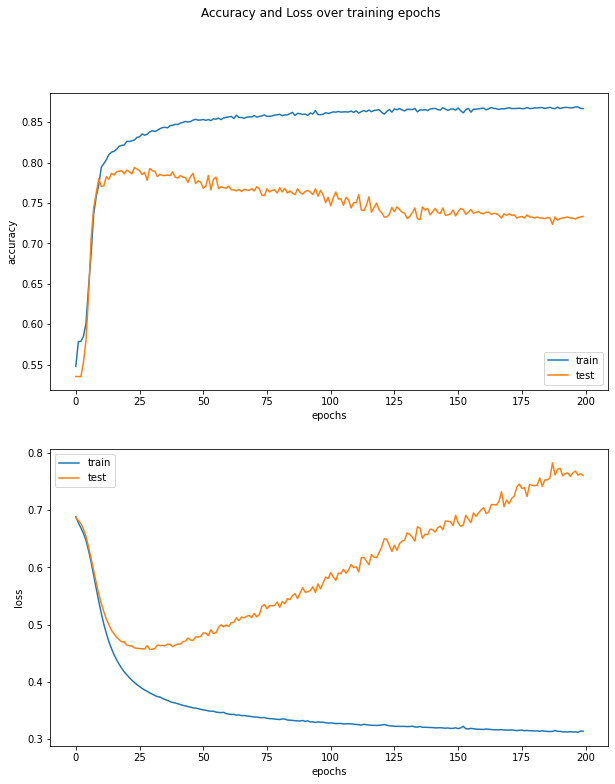


**** conclusion for the simple embedding neural network model ****
The best score on test data is 0.7939 and has been reached after 24 epochs.


In [85]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1)

fig.set_size_inches(w=10, h=12)
fig.suptitle('Accuracy and Loss over training epochs')

# Visualize train and test Accuracy
ax1.plot(model_emb.history.history["binary_accuracy"], label="train")
ax1.plot(model_emb.history.history["val_binary_accuracy"], label="test")
ax1.legend(loc="lower right")
ax1.set_xlabel('epochs')
ax1.set_ylabel('accuracy')


# Visualize train and test Loss
ax2.plot(model_emb.history.history["loss"], label="train")
ax2.plot(model_emb.history.history["val_loss"], label="test")
ax2.legend(loc="upper left")
ax2.set_xlabel('epochs')
ax2.set_ylabel('loss')

plt.show()
print('\n**** conclusion for the simple embedding neural network model ****')
print('The best score on test data is {:.4} and has been reached after {:d} epochs.'.format(
          np.max(model_emb.history.history["val_binary_accuracy"]),
          np.argmax(model_emb.history.history["val_binary_accuracy"]) +1 ))

## 3. Recurent Neural Network (Simple Recurrent Neural)


In [51]:
model_RNN = tf.keras.Sequential([
                  # layer for input Word Embedding        
                  tf.keras.layers.Embedding(vocab_size + 1,
                                            128, input_shape=[tweet.shape[1],], name="embedding"),
                  # Simple RNN layers  
                  tf.keras.layers.SimpleRNN(units=128, return_sequences=True), # maintains the sequential nature
                  tf.keras.layers.SimpleRNN(units=64, return_sequences=False), # returns the last output

                  tf.keras.layers.Dense(16, activation="relu"),  # this layer improves how quick the model can learn but can also lead to overfitting-
                  tf.keras.layers.Dense(1, activation="sigmoid") # exit layer : simple neuron with sigmoid activation consideing the classification problem (0/1)
                  ])

In [52]:
model_RNN.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 128)           128128    
_________________________________________________________________
simple_rnn_18 (SimpleRNN)    (None, 30, 128)           32896     
_________________________________________________________________
simple_rnn_19 (SimpleRNN)    (None, 64)                12352     
_________________________________________________________________
dense_18 (Dense)             (None, 16)                1040      
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 17        
Total params: 174,433
Trainable params: 174,433
Non-trainable params: 0
_________________________________________________________________


In [53]:
optimizer= tf.keras.optimizers.Adam(10**-3)

model_RNN.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

In [54]:
# Training of the model with RNN 
history = model_RNN.fit(train_data, 
                            epochs=20, 
                            validation_data=test_data)

Epoch 1/20
24/24 [==============================] - 4s 100ms/step - loss: 0.6306 - binary_accuracy: 0.6406 - val_loss: 0.5712 - val_binary_accuracy: 0.7235
Epoch 2/20
24/24 [==============================] - 2s 84ms/step - loss: 0.4487 - binary_accuracy: 0.8006 - val_loss: 0.5222 - val_binary_accuracy: 0.7630
Epoch 3/20
24/24 [==============================] - 2s 85ms/step - loss: 0.3407 - binary_accuracy: 0.8626 - val_loss: 0.5684 - val_binary_accuracy: 0.7406
Epoch 4/20
24/24 [==============================] - 2s 86ms/step - loss: 0.2734 - binary_accuracy: 0.8956 - val_loss: 0.6642 - val_binary_accuracy: 0.7301
Epoch 5/20
24/24 [==============================] - 2s 86ms/step - loss: 0.2278 - binary_accuracy: 0.9127 - val_loss: 0.7370 - val_binary_accuracy: 0.6926
Epoch 6/20
24/24 [==============================] - 2s 84ms/step - loss: 0.1987 - binary_accuracy: 0.9269 - val_loss: 0.7125 - val_binary_accuracy: 0.7630
Epoch 7/20
24/24 [==============================] - 2s 86ms/step - lo

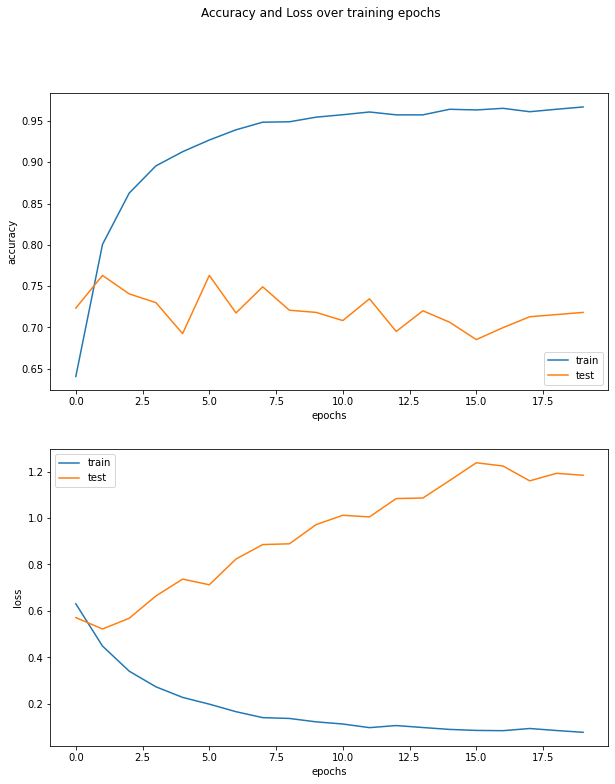

In [55]:
fig, (ax1, ax2) = plt.subplots(2, 1)

fig.set_size_inches(w=10, h=12)
fig.suptitle('Accuracy and Loss over training epochs')

# Visualize train and test Accuracy
ax1.plot(model_RNN.history.history["binary_accuracy"], label="train")
ax1.plot(model_RNN.history.history["val_binary_accuracy"], label="test")
ax1.legend(loc="lower right")
ax1.set_xlabel('epochs')
ax1.set_ylabel('accuracy')


# Visualize train and test Loss
ax2.plot(model_RNN.history.history["loss"], label="train")
ax2.plot(model_RNN.history.history["val_loss"], label="test")
ax2.legend(loc="upper left")
ax2.set_xlabel('epochs')
ax2.set_ylabel('loss')

plt.show()

### We can clearly see from the results and graph above that this model overfits very quickly : the loss on test set starts to increase on the 3rd epoch. However, we can also note that the model can be extremely performing on train data : it reaches an accuracy of almost 97%.

### Thus, we need to regularize the model in order to reduce the overfitting and to be able to exploit the potential of the model.

### To regularize neural networks, we can use several techniques such as 

*   early stopping (stop training when Loss function starts to increase on test dataset)
*   weight penalization using L1 norm (sum of the absolute weights) or L2 norm (sum of the squared weights) for example
*   reducing the model complexity
*   reducing the optimizer learning rate
*   add 'dropout' layers : remove nodes randomly during the training.

#### For this project, we choose to focus on simplyfing the model (by reducing the number of neurons), reducing the learning rate and add some 'drop out' layers.



In [56]:
model_RNN_regul = tf.keras.Sequential([
                  # layer for input Word Embedding          
                  tf.keras.layers.Embedding(vocab_size + 1,
                                            64, input_shape=[tweet.shape[1],], name="embedding"),
                  # Simple RNN layer
                  tf.keras.layers.SimpleRNN(units=64, return_sequences=True), # maintains the sequential nature
                  # Dropout layer
                  tf.keras.layers.Dropout(rate=0.5),

                  # Simple RNN layer
                  tf.keras.layers.SimpleRNN(units=16, return_sequences=False), # returns the last output
                  # Dropout layer
                  tf.keras.layers.Dropout(rate=0.5),

                  tf.keras.layers.Dense(8, activation="relu"),  # this layer improves how quick the model can learn but can also lead to overfitting-
                  tf.keras.layers.Dense(1, activation="sigmoid") # exit layer : simple neuron with sigmoid activation consideing the classification problem (0/1)
                  ])

In [57]:
model_RNN_regul.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 64)            64064     
_________________________________________________________________
simple_rnn_20 (SimpleRNN)    (None, 30, 64)            8256      
_________________________________________________________________
dropout_13 (Dropout)         (None, 30, 64)            0         
_________________________________________________________________
simple_rnn_21 (SimpleRNN)    (None, 16)                1296      
_________________________________________________________________
dropout_14 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_21 (Dense)             (None, 1)               

In [58]:
optimizer= tf.keras.optimizers.Adam(learning_rate=10**-4)

model_RNN_regul.compile(optimizer=optimizer,
                        loss=tf.keras.losses.BinaryCrossentropy(),
                        metrics=[tf.keras.metrics.BinaryAccuracy()])

In [59]:
# Training of the model with RNN 
history = model_RNN_regul.fit(train_data, 
                            epochs=20, 
                            validation_data=test_data)

Epoch 1/20
24/24 [==============================] - 4s 94ms/step - loss: 0.7202 - binary_accuracy: 0.5212 - val_loss: 0.6959 - val_binary_accuracy: 0.5425
Epoch 2/20
24/24 [==============================] - 2s 81ms/step - loss: 0.7033 - binary_accuracy: 0.5446 - val_loss: 0.6873 - val_binary_accuracy: 0.5517
Epoch 3/20
24/24 [==============================] - 2s 84ms/step - loss: 0.6899 - binary_accuracy: 0.5593 - val_loss: 0.6816 - val_binary_accuracy: 0.5537
Epoch 4/20
24/24 [==============================] - 2s 85ms/step - loss: 0.6798 - binary_accuracy: 0.5715 - val_loss: 0.6698 - val_binary_accuracy: 0.5635
Epoch 5/20
24/24 [==============================] - 2s 87ms/step - loss: 0.6727 - binary_accuracy: 0.5901 - val_loss: 0.6555 - val_binary_accuracy: 0.5905
Epoch 6/20
24/24 [==============================] - 2s 84ms/step - loss: 0.6539 - binary_accuracy: 0.6242 - val_loss: 0.6295 - val_binary_accuracy: 0.6623
Epoch 7/20
24/24 [==============================] - 2s 86ms/step - los

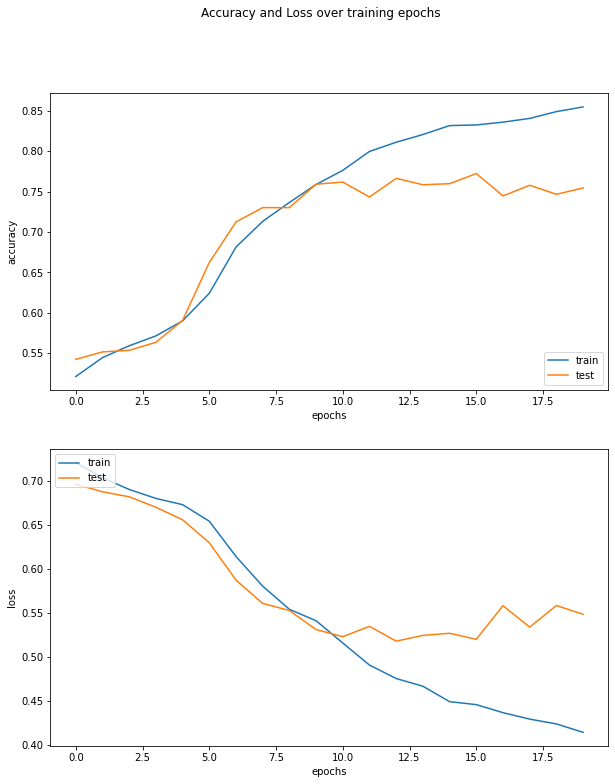


**** conclusion for  RNN after regularization ****
The best score on test data is 0.7722 and has been reached after 16 epochs.


In [60]:
fig, (ax1, ax2) = plt.subplots(2, 1)

fig.set_size_inches(w=10, h=12)
fig.suptitle('Accuracy and Loss over training epochs')

# Visualize train and test Accuracy
ax1.plot(model_RNN_regul.history.history["binary_accuracy"], label="train")
ax1.plot(model_RNN_regul.history.history["val_binary_accuracy"], label="test")
ax1.legend(loc="lower right")
ax1.set_xlabel('epochs')
ax1.set_ylabel('accuracy')


# Visualize train and test Loss
ax2.plot(model_RNN_regul.history.history["loss"], label="train")
ax2.plot(model_RNN_regul.history.history["val_loss"], label="test")
ax2.legend(loc="upper left")
ax2.set_xlabel('epochs')
ax2.set_ylabel('loss')

plt.show()


print('\n**** conclusion for  RNN after regularization ****')
print('The best score on test data is {:.4} and has been reached after {:d} epochs.'.format(
          np.max(model_RNN_regul.history.history["val_binary_accuracy"]),
          np.argmax(model_RNN_regul.history.history["val_binary_accuracy"]) +1 ))

#### Even though we managed to reduce overfitting, accuracy on train data is still really higher than accuracy on test data. Eventually, we reached a perfomance close to the one obtained with a simple embedding layer. We will now try to improve the accuracy by using Long Short Term Memoyer layers.

##5.   Complex recurrent layers (LSTM)

In [92]:
model_LSTM = tf.keras.Sequential([
                  # layer for input Word Embedding           
                  tf.keras.layers.Embedding(vocab_size + 1,
                                            128, input_shape=[tweet.shape[1],], name="embedding"),
                                  
                  # LSTM Bidirectional layer
                  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=128, return_sequences=True)), # maintains the sequential nature
                  
                  # LSTM Bidirectional layer
                  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=64, return_sequences=False)), # returns the last output

                  tf.keras.layers.Dense(8, activation="relu"),  # this layer improves how quick the model can learn but can also lead to overfitting-
                  tf.keras.layers.Dense(1, activation="sigmoid") # exit layer : simple neuron with sigmoid activation consideing the classification problem (0/1)
                  ])

In [93]:
model_LSTM.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 128)           128128    
_________________________________________________________________
bidirectional_8 (Bidirection (None, 30, 256)           263168    
_________________________________________________________________
bidirectional_9 (Bidirection (None, 128)               164352    
_________________________________________________________________
dense_40 (Dense)             (None, 8)                 1032      
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 9         
Total params: 556,689
Trainable params: 556,689
Non-trainable params: 0
_________________________________________________________________


In [94]:
optimizer= tf.keras.optimizers.Adam(learning_rate=10**-3)

model_LSTM.compile(optimizer=optimizer,
                        loss=tf.keras.losses.BinaryCrossentropy(),
                        metrics=[tf.keras.metrics.BinaryAccuracy()])

In [95]:
# Training of the model with LSTM 
history = model_LSTM.fit(train_data, 
                            epochs=100, 
                            validation_data=test_data)

Epoch 1/100
24/24 [==============================] - 9s 115ms/step - loss: 0.6543 - binary_accuracy: 0.6102 - val_loss: 0.5801 - val_binary_accuracy: 0.7518
Epoch 2/100
24/24 [==============================] - 1s 45ms/step - loss: 0.4701 - binary_accuracy: 0.7950 - val_loss: 0.4845 - val_binary_accuracy: 0.7722
Epoch 3/100
24/24 [==============================] - 1s 45ms/step - loss: 0.4105 - binary_accuracy: 0.8203 - val_loss: 0.4760 - val_binary_accuracy: 0.7775
Epoch 4/100
24/24 [==============================] - 1s 45ms/step - loss: 0.3794 - binary_accuracy: 0.8401 - val_loss: 0.4609 - val_binary_accuracy: 0.7854
Epoch 5/100
24/24 [==============================] - 1s 46ms/step - loss: 0.3652 - binary_accuracy: 0.8523 - val_loss: 0.4964 - val_binary_accuracy: 0.7716
Epoch 6/100
24/24 [==============================] - 1s 45ms/step - loss: 0.3532 - binary_accuracy: 0.8589 - val_loss: 0.5048 - val_binary_accuracy: 0.7617
Epoch 7/100
24/24 [==============================] - 1s 45ms/st

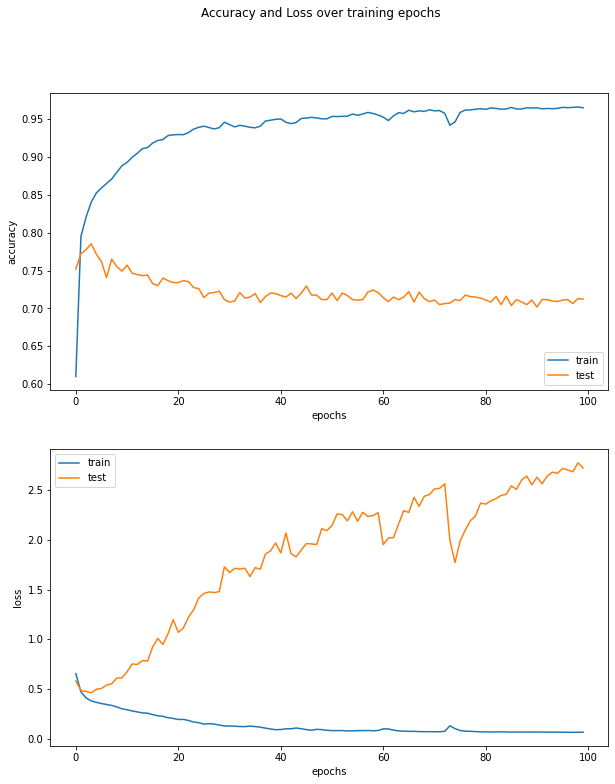

In [96]:
fig, (ax1, ax2) = plt.subplots(2, 1)

fig.set_size_inches(w=10, h=12)
fig.suptitle('Accuracy and Loss over training epochs')

# Visualize train and test Accuracy
ax1.plot(model_LSTM.history.history["binary_accuracy"], label="train")
ax1.plot(model_LSTM.history.history["val_binary_accuracy"], label="test")
ax1.legend(loc="lower right")
ax1.set_xlabel('epochs')
ax1.set_ylabel('accuracy')


# Visualize train and test Loss
ax2.plot(model_LSTM.history.history["loss"], label="train")
ax2.plot(model_LSTM.history.history["val_loss"], label="test")
ax2.legend(loc="upper left")
ax2.set_xlabel('epochs')
ax2.set_ylabel('loss')

plt.show()

#### As for the RNN, we can see that the model overfits quickly and presents very appealing performance on train data. We will apply the same regularization techniques as before (reduce the learning rate, reduce the model complexity and add some 'drop out' layers) in order to improve the performances of the LSTM model.

In [123]:
model_LSTM_regul = tf.keras.Sequential([
                  # layer for input Word Embedding           
                  tf.keras.layers.Embedding(vocab_size + 1,
                                            128, input_shape=[tweet.shape[1],], name="embedding"),

                  tf.keras.layers.Dropout(rate=0.6),

                  # LSTM Bidirectional layer
                  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=128, return_sequences=True)), # maintains the sequential nature
                  
                  tf.keras.layers.Dropout(rate=0.5),

                  # LSTM Bidirectional layer
                  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=32, return_sequences=False)), # returns the last output

                  # Dropout layer
                  tf.keras.layers.Dropout(rate=0.5),

                  tf.keras.layers.Dense(4, activation="relu"),  # this layer improves how quick the model can learn but can also lead to overfitting-
                  tf.keras.layers.Dense(1, activation="sigmoid") # exit layer : simple neuron with sigmoid activation consideing the classification problem (0/1)
                  ])

In [124]:
model_LSTM_regul.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 128)           128128    
_________________________________________________________________
dropout_51 (Dropout)         (None, 30, 128)           0         
_________________________________________________________________
bidirectional_18 (Bidirectio (None, 30, 256)           263168    
_________________________________________________________________
dropout_52 (Dropout)         (None, 30, 256)           0         
_________________________________________________________________
bidirectional_19 (Bidirectio (None, 64)                73984     
_________________________________________________________________
dropout_53 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_54 (Dense)             (None, 4)               

In [125]:
optimizer= tf.keras.optimizers.Adam(learning_rate=10**-4)

model_LSTM_regul.compile(optimizer=optimizer,
                        loss=tf.keras.losses.BinaryCrossentropy(),
                        metrics=[tf.keras.metrics.BinaryAccuracy()])

In [126]:
# Training of the model with LSTM 
history_LSTM_regul = model_LSTM_regul.fit(train_data, 
                            epochs=100, 
                            validation_data=test_data)

Epoch 1/100
24/24 [==============================] - 9s 111ms/step - loss: 0.6850 - binary_accuracy: 0.5771 - val_loss: 0.6896 - val_binary_accuracy: 0.5352
Epoch 2/100
24/24 [==============================] - 1s 42ms/step - loss: 0.6797 - binary_accuracy: 0.5784 - val_loss: 0.6901 - val_binary_accuracy: 0.5352
Epoch 3/100
24/24 [==============================] - 1s 42ms/step - loss: 0.6776 - binary_accuracy: 0.5784 - val_loss: 0.6869 - val_binary_accuracy: 0.5352
Epoch 4/100
24/24 [==============================] - 1s 43ms/step - loss: 0.6737 - binary_accuracy: 0.5784 - val_loss: 0.6839 - val_binary_accuracy: 0.5352
Epoch 5/100
24/24 [==============================] - 1s 42ms/step - loss: 0.6675 - binary_accuracy: 0.5784 - val_loss: 0.6731 - val_binary_accuracy: 0.5352
Epoch 6/100
24/24 [==============================] - 1s 42ms/step - loss: 0.6427 - binary_accuracy: 0.5927 - val_loss: 0.6262 - val_binary_accuracy: 0.6452
Epoch 7/100
24/24 [==============================] - 1s 43ms/st

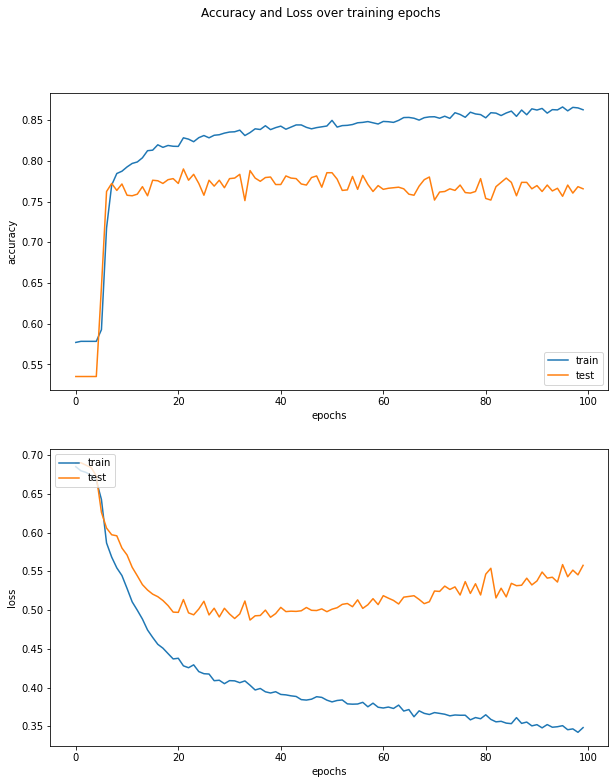


**** conclusion for LSTM after regularization ****
The best score on test data is 0.79 and has been reached after 22 epochs.


In [128]:
fig, (ax1, ax2) = plt.subplots(2, 1)

fig.set_size_inches(w=10, h=12)
fig.suptitle('Accuracy and Loss over training epochs')

# Visualize train and test Accuracy
ax1.plot(model_LSTM_regul.history.history["binary_accuracy"], label="train")
ax1.plot(model_LSTM_regul.history.history["val_binary_accuracy"], label="test")
ax1.legend(loc="lower right")
ax1.set_xlabel('epochs')
ax1.set_ylabel('accuracy')


# Visualize train and test Loss
ax2.plot(model_LSTM_regul.history.history["loss"], label="train")
ax2.plot(model_LSTM_regul.history.history["val_loss"], label="test")
ax2.legend(loc="upper left")
ax2.set_xlabel('epochs')
ax2.set_ylabel('loss')

plt.show()


print('\n**** conclusion for LSTM after regularization ****')
print('The best score on test data is {:.4} and has been reached after {:d} epochs.'.format(
          np.max(model_LSTM_regul.history.history["val_binary_accuracy"]),
          np.argmax(model_LSTM_regul.history.history["val_binary_accuracy"]) +1 ))

#### Even though we managed to reduce drastically overfitting on the LSTM model and obtain a decent score (0.79), we didn't manage to really improve the accuracy compared to a simple embedding layer.

#### As next steps, it seems relevant to explore other regularization techniques to determine wether we can bring accuracy on test even closer to accuracy on train.

## Conclusion of the project

#### We explored different modeling possibilities in order to predict with the best possible accuracy wether a tweet was indeed related to a natural disaster or not. The scores obtained were very close even though the complexity of the models used was increasing (logistic regression, simple embedding, RNN and finally LSTM). As next steps, it seems relevant to explore other regularization techniques on RNN and LSTM trying to reduce even more the gap between train and test performances.

#### Accuracy on test data :


*   logistic regression with TF-IDF : 0.8035
*   Simple embedding : 0.7939
*   RNN : 0.7722
*   LSTM : 0.7900

